In [1]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from datasets import load_dataset
from transformers import AutoTokenizer
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import evaluate
import json

import torch
torch.cuda.empty_cache()


c:\Users\Revalda Putawara\.conda\envs\mbgsentiment\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [3]:
files = {
    "train": r"dataset/train/train.csv", 
    "eval": r"dataset/train/eval.csv", 
    "test": r"dataset/train/test.csv",
}

dataset = load_dataset('csv', data_files=files)

## Tokenizer and Model load

In [4]:
#"indolem/indobert-base-uncased" ==> can't predict class 1

#indolem/indobert-base-uncased
#ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa
#cahya/bert-base-indonesian-522M
#google-bert/bert-base-uncased

# key value pair. key will be supplied to model_choice variable
model_name = {"indobert_base":"indobenchmark/indobert-base-p2",
              "ayamerushia":"ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa",
              "cahya":"cahya/bert-base-indonesian-522M",
              "google-bert":"google-bert/bert-base-uncased"}

In [5]:
model_choice = "ayamerushia"
model_serial = model_choice + "_" + datetime.strftime(datetime.now(),format="%y%m%d-%H%M%S")

print(model_serial)

ayamerushia_250206-195414


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name[model_choice])

In [7]:
def tokenize_function(text):
    return tokenizer(text["text"], padding='max_length', max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

In [8]:
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["eval"]

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(model_name[model_choice], num_labels=3)

In [10]:
training_args = TrainingArguments(
    "test_trainer_"+model_serial, 
    per_device_train_batch_size=4,
    num_train_epochs=2,
    #label_names=["label"],
    logging_strategy="epoch",
    evaluation_strategy="epoch", 
)

C:\Users\Revalda Putawara\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
accuracy = evaluate.load("accuracy")

In [12]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return accuracy.compute(predictions=predictions, references=labels)

In [13]:
f1_metric = evaluate.load("f1")

def compute_f1(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return f1_metric.compute(predictions=predictions, references=labels)

## Start Training

In [14]:
torch.cuda.empty_cache()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

training_history = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.804800,0.781006,0.765607
2,0.460700,0.829862,0.802120


In [16]:
trainer.state.log_history

[{'loss': 0.8048,
  'grad_norm': 1.227738618850708,
  'learning_rate': 2.5e-05,
  'epoch': 1.0,
  'step': 944},
 {'eval_loss': 0.7810059785842896,
  'eval_accuracy': 0.7656065959952886,
  'eval_runtime': 19.8684,
  'eval_samples_per_second': 42.731,
  'eval_steps_per_second': 5.385,
  'epoch': 1.0,
  'step': 944},
 {'loss': 0.4607,
  'grad_norm': 1.4361923933029175,
  'learning_rate': 0.0,
  'epoch': 2.0,
  'step': 1888},
 {'eval_loss': 0.8298623561859131,
  'eval_accuracy': 0.8021201413427562,
  'eval_runtime': 24.5705,
  'eval_samples_per_second': 34.554,
  'eval_steps_per_second': 4.355,
  'epoch': 2.0,
  'step': 1888},
 {'train_runtime': 790.4286,
  'train_samples_per_second': 9.547,
  'train_steps_per_second': 2.389,
  'total_flos': 992726925087744.0,
  'train_loss': 0.6327589972544525,
  'epoch': 2.0,
  'step': 1888}]

In [26]:
epochs = []
steps = []
losses = []
val_losses = []

for log in trainer.state.log_history:
    if "eval_loss" in log: 
        epochs.append(log["epoch"])
        #losses.append(log["loss"])
        val_losses.append(log["eval_loss"])
    if "loss" in log: 
        #steps.append(log["epoch"])
        #losses.append(log["loss"])
        losses.append(log["loss"])

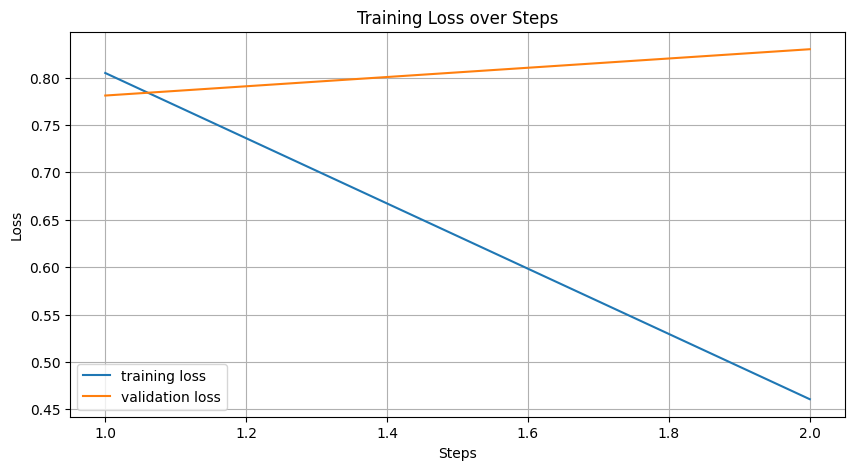

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, losses, label="training loss")
plt.plot(epochs, val_losses, label="validation loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.legend()
plt.grid()
plt.show()

In [16]:
model.save_pretrained("model_"+model_serial)

## Evaluation

In [28]:
test_dataset = tokenized_datasets["test"]

prediction = trainer.predict(test_dataset)
prediction = prediction.predictions.argmax(1)

In [26]:
pd.DataFrame(prediction).to_csv(r"result_prediction/prediction_"+model_serial+'.csv',index=False)

In [29]:
df_test=pd.read_csv(r"dataset/train/test.csv")
actual_label = df_test['label']

In [30]:
print(classification_report(prediction, actual_label, target_names=["Negatif", "Netral", "Positif"]))

              precision    recall  f1-score   support

     Negatif       0.93      0.93      0.93        42
      Netral       0.76      0.79      0.78        24
     Positif       0.89      0.86      0.88        29

    accuracy                           0.87        95
   macro avg       0.86      0.86      0.86        95
weighted avg       0.88      0.87      0.87        95



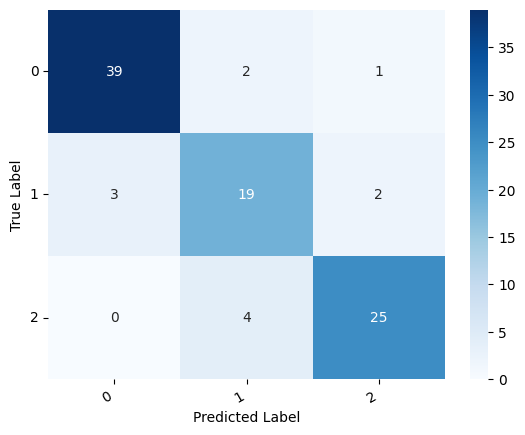

In [31]:
def show_confusion_matrix(confusion_matrix):
        hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

cm = confusion_matrix(prediction, actual_label)
show_confusion_matrix(cm)

In [32]:
f1_metric.compute(predictions=prediction, references=actual_label, average="weighted")

{'f1': 0.8731490380085553}

## Save Training Result

In [27]:
save_dict = {}
save_dict["trainer_history"] = trainer.state.log_history
save_dict["trainer_args"] = trainer.args.to_dict()
save_dict["trainer_model_config"] = trainer.model.config.to_dict()

In [30]:
with open(r"result_model/result_"+model_serial+'.json', 'w', encoding='utf-8') as f:
    json.dump(save_dict, f, ensure_ascii=False, indent=4)